In [439]:
import torch
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random

np.random.seed(493)
torch.manual_seed(493)
random.seed(493)

print('sucess')

sucess


In [440]:
df = pd.read_csv("nba_games.csv")
df_test = pd.read_csv("nba_games_test.csv")
df = pd.concat((df, df_test), axis=0)
df = df.sort_values(['date'])
#reset indices to be based on date; drop old index column
df = df.reset_index(drop=True)
# print(list(df.columns))
df.head(17)

,Unnamed: 0,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,...,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won
0,16087,240.0,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,...,37.5,38.9,201.0,120.0,NOP,95,0,2016,2015-10-27,True
1,1224,240.0,240.0,37.0,96.0,0.385,12.0,29.0,0.414,20.0,...,57.1,33.8,258.0,121.0,ATL,94,1,2016,2015-10-27,True
2,1225,240.0,240.0,37.0,82.0,0.451,8.0,27.0,0.296,12.0,...,33.3,23.6,132.0,104.0,DET,106,0,2016,2015-10-27,False
3,16905,240.0,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,...,30.4,29.0,138.0,105.0,CLE,95,0,2016,2015-10-27,True
4,16086,240.0,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,...,69.4,43.7,206.0,104.0,GSW,111,1,2016,2015-10-27,False
5,16904,240.0,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,...,53.2,34.6,162.0,104.0,CHI,97,1,2016,2015-10-27,False
6,3613,240.0,240.0,29.0,82.0,0.354,2.0,16.0,0.125,16.0,...,100.0,28.0,149.0,89.0,CLE,106,0,2016,2015-10-28,False
7,3612,240.0,240.0,41.0,84.0,0.488,13.0,29.0,0.448,11.0,...,42.4,40.5,97.0,119.0,MEM,76,1,2016,2015-10-28,True
8,3553,240.0,240.0,36.0,80.0,0.450,7.0,18.0,0.389,27.0,...,16.8,31.1,127.0,110.0,IND,99,0,2016,2015-10-28,True
9,3552,240.0,240.0,32.0,86.0,0.372,9.0,23.0,0.391,26.0,...,100.0,29.7,134.0,105.0,TOR,106,1,2016,2015-10-28,False


In [441]:
features = ['ts%', '+/-_max_opp', '+/-_max', 'orb%', 'drb%', 'ast%', 'stl%', \
                 'blk%', 'tov%', '3par', 'ftr', 'ts%_opp', 'drb%_opp', 'orb%_opp', \
                 'ast%_opp', 'stl%_opp', 'blk%_opp', 'tov%_opp', '3par_opp', 'ftr_opp', \
                 'home_opp']
relevant = ['ts%', '+/-_max_opp', '+/-_max', 'orb%', 'drb%', 'ast%', 'stl%', \
                 'blk%', 'tov%', '3par', 'ftr', 'ts%_opp', 'drb%_opp', 'orb%_opp', \
                 'ast%_opp', 'stl%_opp', 'blk%_opp', 'tov%_opp', '3par_opp', 'ftr_opp', \
                 'home_opp', 'won', 'team', 'date']
df_no_na = df[relevant].dropna()

In [442]:
# Add match numbers for each team

df2 = df_no_na.copy(deep=True)
df2 = df2.sort_values(['team', 'date']).reset_index(drop=True)
df2['idx'] = 0

team = ""
game_num = 1
for i in np.arange(len(df2)):
    if df2.loc[i]['team'] != team:
        game_num = 1
    else:
        game_num += 1
    df2.at[i, 'idx'] = game_num
    team = df2.loc[i]['team']
    
df2 = df2.sort_values('date').reset_index(drop=True)
df2.head(17)

,ts%,+/-_max_opp,+/-_max,orb%,drb%,ast%,stl%,blk%,tov%,3par,...,stl%_opp,blk%_opp,tov%_opp,3par_opp,ftr_opp,home_opp,won,team,date,idx
0,0.530,26.0,10.0,16.3,58.9,59.5,9.4,6.0,14.5,0.329,...,5.2,5.5,12.3,0.302,0.271,0,False,ATL,2015-10-27,1
1,0.493,10.0,26.0,41.1,83.7,62.2,5.2,5.5,12.3,0.302,...,9.4,6.0,14.5,0.329,0.183,1,True,DET,2015-10-27,1
2,0.525,5.0,20.0,45.7,81.4,70.7,8.0,10.8,15.9,0.313,...,9.0,4.5,15.9,0.217,0.325,0,True,GSW,2015-10-27,1
3,0.499,9.0,9.0,15.2,78.4,35.1,6.0,15.4,11.8,0.218,...,5.0,10.3,9.0,0.309,0.181,0,True,CHI,2015-10-27,1
4,0.501,20.0,5.0,18.6,54.3,60.0,9.0,4.5,15.9,0.217,...,8.0,10.8,15.9,0.313,0.229,1,False,NOP,2015-10-27,1
5,0.468,9.0,9.0,21.6,84.8,68.4,5.0,10.3,9.0,0.309,...,6.0,15.4,11.8,0.218,0.264,1,False,CLE,2015-10-27,1
6,0.563,-1.0,23.0,39.6,62.5,57.1,11.6,10.3,9.2,0.247,...,7.4,5.7,15.3,0.209,0.360,1,True,NYK,2015-10-28,1
7,0.475,29.0,9.0,10.0,85.0,52.8,6.9,3.6,10.0,0.363,...,6.9,6.9,11.3,0.364,0.159,1,False,NOP,2015-10-28,2
8,0.563,8.0,26.0,13.0,76.4,60.0,6.9,4.8,7.5,0.247,...,2.9,4.7,15.1,0.276,0.379,1,True,DAL,2015-10-28,1
9,0.595,9.0,29.0,15.0,90.0,50.0,6.9,6.9,11.3,0.364,...,6.9,3.6,10.0,0.363,0.198,0,True,POR,2015-10-28,1


In [443]:
# Rearrange data to associate stats with the next win

def add_Next_Victory(team):
  team["next_win"] = team["won"].shift(-1) #creates a new column called Next_Victory which shows the outcome of the next game played
  return team

df3 = df2.sort_values(['team', 'date']).reset_index(drop=True)
df3 = df3.groupby("team", group_keys=False).apply(add_Next_Victory)
df3["next_win"][pd.isnull(df3["next_win"])] = 2
df3["next_win"] = df3["next_win"].astype(int, errors="ignore")
df3 = df3.sort_values('date').reset_index(drop=True)
df3.head(17)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,ts%,+/-_max_opp,+/-_max,orb%,drb%,ast%,stl%,blk%,tov%,3par,...,blk%_opp,tov%_opp,3par_opp,ftr_opp,home_opp,won,team,date,idx,next_win
0,0.530,26.0,10.0,16.3,58.9,59.5,9.4,6.0,14.5,0.329,...,5.5,12.3,0.302,0.271,0,False,ATL,2015-10-27,1,1
1,0.493,10.0,26.0,41.1,83.7,62.2,5.2,5.5,12.3,0.302,...,6.0,14.5,0.329,0.183,1,True,DET,2015-10-27,1,1
2,0.525,5.0,20.0,45.7,81.4,70.7,8.0,10.8,15.9,0.313,...,4.5,15.9,0.217,0.325,0,True,GSW,2015-10-27,1,1
3,0.499,9.0,9.0,15.2,78.4,35.1,6.0,15.4,11.8,0.218,...,10.3,9.0,0.309,0.181,0,True,CHI,2015-10-27,1,1
4,0.501,20.0,5.0,18.6,54.3,60.0,9.0,4.5,15.9,0.217,...,10.8,15.9,0.313,0.229,1,False,NOP,2015-10-27,1,0
5,0.468,9.0,9.0,21.6,84.8,68.4,5.0,10.3,9.0,0.309,...,15.4,11.8,0.218,0.264,1,False,CLE,2015-10-27,1,1
6,0.563,-1.0,23.0,39.6,62.5,57.1,11.6,10.3,9.2,0.247,...,5.7,15.3,0.209,0.360,1,True,NYK,2015-10-28,1,0
7,0.475,29.0,9.0,10.0,85.0,52.8,6.9,3.6,10.0,0.363,...,6.9,11.3,0.364,0.159,1,False,NOP,2015-10-28,2,0
8,0.563,8.0,26.0,13.0,76.4,60.0,6.9,4.8,7.5,0.247,...,4.7,15.1,0.276,0.379,1,True,DAL,2015-10-28,1,0
9,0.595,9.0,29.0,15.0,90.0,50.0,6.9,6.9,11.3,0.364,...,3.6,10.0,0.363,0.198,0,True,POR,2015-10-28,1,0


In [444]:
# Compute rolling average of stats up to each game

df4 = df3.sort_values(['team', 'date']).reset_index(drop=True)

def get_seasonal_stats(team):
    for series_name, series in team.items():
        if (series_name in features) and (series_name != 'home_opp'):
            team[series_name] = team[series_name].cumsum() / team['idx']
    return team

df4 = df4.groupby("team", group_keys=False).apply(get_seasonal_stats)
df4 = df4.sort_values('date').reset_index(drop=True)
df4.head(17)

,ts%,+/-_max_opp,+/-_max,orb%,drb%,ast%,stl%,blk%,tov%,3par,...,blk%_opp,tov%_opp,3par_opp,ftr_opp,home_opp,won,team,date,idx,next_win
0,0.530,26.0,10.0,16.30,58.90,59.50,9.40,6.00,14.50,0.3290,...,5.50,12.3,0.3020,0.2710,0,False,ATL,2015-10-27,1,1
1,0.493,10.0,26.0,41.10,83.70,62.20,5.20,5.50,12.30,0.3020,...,6.00,14.5,0.3290,0.1830,1,True,DET,2015-10-27,1,1
2,0.525,5.0,20.0,45.70,81.40,70.70,8.00,10.80,15.90,0.3130,...,4.50,15.9,0.2170,0.3250,0,True,GSW,2015-10-27,1,1
3,0.499,9.0,9.0,15.20,78.40,35.10,6.00,15.40,11.80,0.2180,...,10.30,9.0,0.3090,0.1810,0,True,CHI,2015-10-27,1,1
4,0.501,20.0,5.0,18.60,54.30,60.00,9.00,4.50,15.90,0.2170,...,10.80,15.9,0.3130,0.2290,1,False,NOP,2015-10-27,1,0
5,0.468,9.0,9.0,21.60,84.80,68.40,5.00,10.30,9.00,0.3090,...,15.40,11.8,0.2180,0.2640,1,False,CLE,2015-10-27,1,1
6,0.563,-1.0,23.0,39.60,62.50,57.10,11.60,10.30,9.20,0.2470,...,5.70,15.3,0.2090,0.3600,1,True,NYK,2015-10-28,1,0
7,0.488,24.5,7.0,14.30,69.65,56.40,7.95,4.05,12.95,0.2900,...,8.85,13.6,0.3385,0.1940,1,False,NOP,2015-10-28,2,0
8,0.563,8.0,26.0,13.00,76.40,60.00,6.90,4.80,7.50,0.2470,...,4.70,15.1,0.2760,0.3790,1,True,DAL,2015-10-28,1,0
9,0.595,9.0,29.0,15.00,90.00,50.00,6.90,6.90,11.30,0.3640,...,3.60,10.0,0.3630,0.1980,0,True,POR,2015-10-28,1,0


In [445]:
# Drop "final" games before splitting into train, val, and test
# there 
df5 = df4[df4['next_win'] != 2]

# Redefine featues to be only those which are desired
features = ['ts%', '+/-_max_opp', '+/-_max', 'orb%', 'drb%', 'ast%', 'stl%', \
             'blk%', 'tov%', '3par', 'ftr', 'ts%_opp', 'drb%_opp', 'orb%_opp', \
             'ast%_opp', 'stl%_opp', 'blk%_opp', 'tov%_opp', '3par_opp', 'ftr_opp', \
             'home_opp']

# Get number of features
D = len(features)

y = torch.tensor(df5['next_win'].values.astype(int))
feature_data = df5[features]
X = torch.tensor(feature_data.values, dtype=torch.float)
print(X.shape)
print(y.shape)

torch.Size([19438, 21])
torch.Size([19438])


In [446]:
train_size = int(0.8 * 17742) # 17742 is the last row before test data
val_size = 17742 - train_size
test_size = len(y) - 17742

X_train_small = X[0:100]
y_train_small = y[0:100]

X_train = X[0:train_size]
X_val = X[train_size:17742]
X_test = X[17742:]

y_train = y[0:train_size]
y_val = y[train_size:17742]
y_test = y[17742:]

train_set_small = TensorDataset(X_train_small, y_train_small)
loader_train_small = DataLoader(train_set_small, batch_size=8, 
                          sampler=sampler.SubsetRandomSampler(range(100)))

train_set = TensorDataset(X_train, y_train)
loader_train = DataLoader(train_set, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(train_size)))

val_set = TensorDataset(X_val, y_val)
loader_val = DataLoader(val_set, batch_size=64,
                      sampler=sampler.SubsetRandomSampler(range(val_size)))

test_set = TensorDataset(X_test, y_test)
loader_test = DataLoader(test_set, batch_size=64,
                      sampler=sampler.SubsetRandomSampler(range(test_size)))

In [447]:
print_every = 100

def train(loader, model, optimizer, epochs=1):
#     model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = []
    for e in range(epochs):
        running_loss = 0.0
        for t, (x, y) in enumerate(loader):
            model.train()  # put model to training mode
#             x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

#             if t % print_every == 0:
#                 print('Iteration %d, loss = %.4f' % (t, loss.item()))
#                 check_accuracy(loader_train, model)
#                 check_accuracy(loader_val, model)
#                 print()
            running_loss += loss.item()
        losses.append(running_loss / len(loader))
    plt.plot(range(epochs), losses)


def check_accuracy(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))


Got 75 / 100 correct (75.00)
Got 8757 / 14193 correct (61.70)
Got 1966 / 3549 correct (55.40)


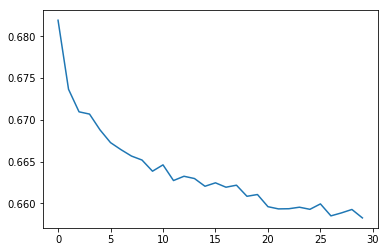

In [528]:
np.random.seed(493)
torch.manual_seed(493)
random.seed(493)

learning_rate = 2e-3
p = 0.0

model = nn.Sequential(
#     nn.LayerNorm(D),
    nn.BatchNorm1d(D),
    nn.Linear(D, 128),nn.BatchNorm1d(128),nn.ReLU(),nn.Dropout(p),
#     nn.Linear(2048, 1024),nn.BatchNorm1d(1024),nn.ReLU(),nn.Dropout(p),
#     nn.Linear(1024, 512),nn.BatchNorm1d(512),nn.ReLU(),nn.Dropout(p),
#     nn.Linear(512, 256),nn.BatchNorm1d(256),nn.ReLU(),nn.Dropout(p),
#     nn.Linear(256, 128),nn.BatchNorm1d(128),nn.ReLU(),nn.Dropout(p),
    nn.Linear(128, 64),nn.BatchNorm1d(64),nn.ReLU(),nn.Dropout(p),
#     nn.Linear(64, 32),nn.BatchNorm1d(32),nn.ReLU(),nn.Dropout(p),
#     nn.Linear(32, 16),nn.BatchNorm1d(16),nn.ReLU(),nn.Dropout(p),
    nn.Linear(64, 2)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.90, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate,
#                       betas=(0.9, 0.999))
train(loader_train, model, optimizer, epochs=30)

check_accuracy(loader_train_small, model)
check_accuracy(loader_train, model)
check_accuracy(loader_val, model)

In [529]:
check_accuracy(loader_test, model)

Got 890 / 1696 correct (52.48)
